In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
seed =7

In [2]:
# transform the data in same dimensions and properties
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [136]:
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████| 9912422/9912422 [00:03<00:00, 3144177.55it/s]


Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/train-images-idx3-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████| 28881/28881 [00:00<00:00, 106421.53it/s]


Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/train-labels-idx1-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████| 1648877/1648877 [00:05<00:00, 311888.66it/s]


Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/t10k-images-idx3-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 1024166.91it/s]


Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/t10k-labels-idx1-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████| 9912422/9912422 [00:12<00:00, 787723.14it/s]


Extracting PATH_TO_STORE_TESTSET/MNIST/raw/train-images-idx3-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████| 28881/28881 [00:00<00:00, 104870.04it/s]


Extracting PATH_TO_STORE_TESTSET/MNIST/raw/train-labels-idx1-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████| 1648877/1648877 [00:07<00:00, 230965.23it/s]


Extracting PATH_TO_STORE_TESTSET/MNIST/raw/t10k-images-idx3-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 1626165.49it/s]

Extracting PATH_TO_STORE_TESTSET/MNIST/raw/t10k-labels-idx1-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw



In [137]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


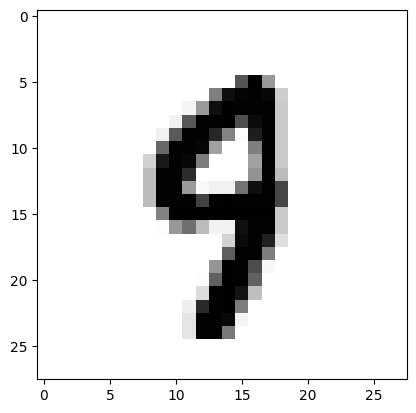

In [138]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

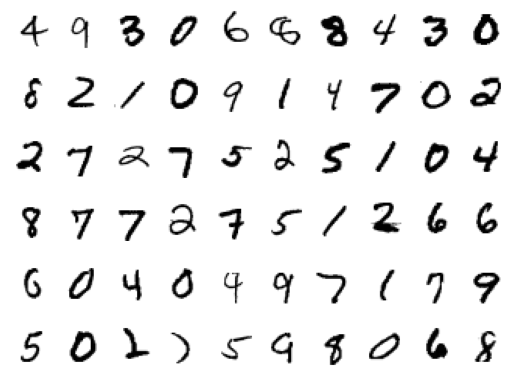

In [139]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')
    plt.savefig('./mnist/img_digits.png')

In [110]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device


device(type='cpu')

In [111]:

class FirstModel(torch.nn.Module):
    def __init__(self):
        super(FirstModel,self).__init__()
        self.conv1 = torch.nn.Conv2d(1,32,3,1)
        self.fc1 = torch.nn.Linear(32*26*26,128)
        self.fc2 = torch.nn.Linear(128,10)
        
    def forward(self,x):
        
        x = F.relu(self.conv1(x))
        x = x.view(-1,32*26*26)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

torch.manual_seed(seed)
first_model = FirstModel().to(device)

In [132]:
first_model

FirstModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=21632, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [112]:
epochs = 10
learning_rate = 1e-2
momentum = 0.5

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(first_model.parameters(),lr=learning_rate,momentum=momentum)

In [122]:
def book_keeping(epoch,time,model):
    
    train_correct_predictions = 0
    test_correct_predictions = 0
    train_epoch_loss = 0
    test_epoch_loss = 0

    for batchX,batchY in iter(train_loader):
        
        batchX, batchY = batchX.to(device), batchY.to(device)
        
        outputs = model(batchX)
        loss = criterion(outputs,batchY)
        train_epoch_loss += loss.item()

        predictions = torch.argmax(outputs.data, 1)
        train_correct_predictions+= (predictions == batchY).sum().item()
        
    for batchX,batchY in iter(test_loader):
        batchX, batchY = batchX.to(device), batchY.to(device)

        outputs = model(batchX)
        loss = criterion(outputs,batchY)
        test_epoch_loss += loss.item()
        
        predictions = torch.argmax(outputs.data, 1)
        test_correct_predictions+= (predictions == batchY).sum().item()
    
    train_acc = (train_correct_predictions / (len(train_loader)*32)) * 100
    test_acc = (test_correct_predictions / (len(test_loader)*32)) * 100
    
    print('Epoch = {}, Time = {}, Train Loss: {:.2f}, Test Loss: {:.2f}, Train Accuracy: {:.2f}%,Test Accuracy: {:.2f}%'.format(epoch + 1, time, train_epoch_loss,test_epoch_loss,train_acc,test_acc))
    
    train_losses.append(train_epoch_loss)
    test_losses.append(test_epoch_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

In [114]:
train_losses,test_losses,train_accs,test_accs = [],[],[],[]

In [116]:
kwargs = {'num_workers': 10, 'pin_memory': True} # GPU
# kwargs = {'num_workers': 1, 'pin_memory': False} # CPU

train_loader = torch.utils.data.DataLoader(trainset,batch_size=32,shuffle=True,**kwargs)
test_loader = torch.utils.data.DataLoader(valset,batch_size=32,shuffle=True,**kwargs)

/Users/nebula/opt/anaconda3/envs/defaultEnv/lib/python3.8/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [123]:
from datetime import datetime
def train(model):
    
    for i in range(10):
        start = datetime.now()

        for batchX,batchY in iter(train_loader):

            batchX, batchY = batchX.to(device), batchY.to(device)

            optimizer.zero_grad()
            outputs = model(batchX)

            loss = criterion(outputs,batchY)

            loss.backward()
            optimizer.step()

        end = datetime.now()
        time = (end-start).total_seconds()
        book_keeping(i,time,model)

train(first_model)

Epoch = 1, Time = 35.903663, Train Loss: 90.74, Test Loss: 20.32, Train Accuracy: 98.64%,Test Accuracy: 97.81%
Epoch = 2, Time = 39.869202, Train Loss: 62.56, Test Loss: 16.39, Train Accuracy: 99.11%,Test Accuracy: 98.24%
Epoch = 3, Time = 41.431146, Train Loss: 49.51, Test Loss: 15.22, Train Accuracy: 99.35%,Test Accuracy: 98.36%
Epoch = 4, Time = 44.044008, Train Loss: 41.63, Test Loss: 15.87, Train Accuracy: 99.45%,Test Accuracy: 98.17%
Epoch = 5, Time = 42.328049, Train Loss: 29.51, Test Loss: 14.15, Train Accuracy: 99.62%,Test Accuracy: 98.38%
Epoch = 6, Time = 42.740772, Train Loss: 24.01, Test Loss: 14.50, Train Accuracy: 99.70%,Test Accuracy: 98.31%
Epoch = 7, Time = 46.230976, Train Loss: 20.37, Test Loss: 14.64, Train Accuracy: 99.79%,Test Accuracy: 98.23%
Epoch = 8, Time = 42.543826, Train Loss: 16.07, Test Loss: 14.72, Train Accuracy: 99.88%,Test Accuracy: 98.30%
Epoch = 9, Time = 44.164628, Train Loss: 12.72, Test Loss: 13.81, Train Accuracy: 99.88%,Test Accuracy: 98.40%
E

(32, 3, 3)


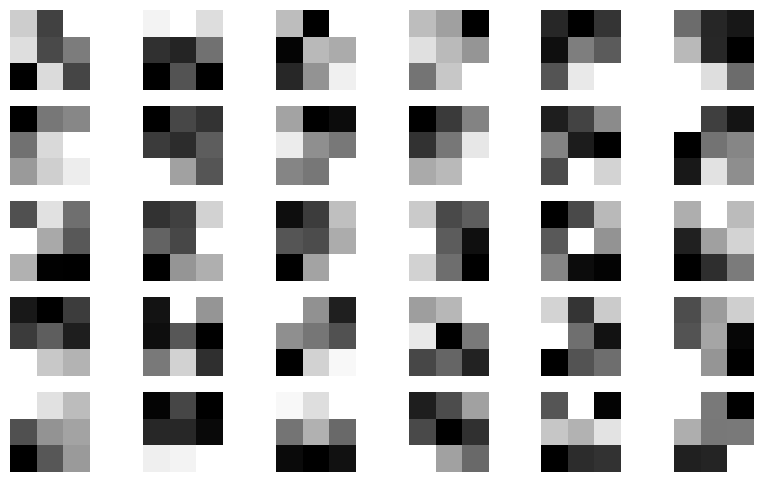

In [134]:
conv1 = [i for i in first_model.children()][0]
conv1_weights = conv1.weight.detach().cpu().numpy().squeeze()
print(conv1_weights.shape)

figure = plt.figure(figsize=(10,6))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.axis("off")
    plt.imshow(conv1_weights[i],cmap="gray")
    plt.savefig("firstweightplot.png")

In [131]:
torch.save(model, './mnist/mnist.pt') 